<h3 style="size: 155px;">INTRODUCTION</h3>

In this project, we aim to predict the power output of a wind turbine using machine learning techniques. We use a dataset containing various environmental and operational features of a wind turbine, such as wind speed, wind direction, air density, turbulence intensity, and more, along with the actual power output of the turbine. We explore three different machine learning models, namely Random Forest Regression, XGBoost, and Linear Support Vector Regression (LinearSVR), to predict the power output based on these features. We evaluate the performance of each model using Mean Absolute Error (MAE), Mean Squared Error (MSE), and R2 score. Finally, we compare the performance of the models and provide insights and conclusions based on our analysis.

<p></p>

<h3 style="size: 155px;">DATA DESCRIPTION</h3>
<p>Data included in these datasets are 10-minute data generated from six wind turbines and three met masts and are arranged in six files, each of which is associated with a turbine. The six turbines are named WT1 through WT6, respectively. All seven environmental variables as mentioned above are available, namely x =(V, D, rho, H, I, Sa, Sb), whereas on the inland wind 
farm, the humidity measurements are not available, nor is the above-hub wind shear, meaning that x =(V, D, rho, I, Sb). 

Variables in x were measured by sensors on the met mast, whereas y was measured at the wind turbines. Each met mast has two wind turbines associated with it, meaning that the x's measured at a met mast are paired with the y's of two associated turbines. For WT1 and WT2, the data were collected from July 30, 2010 through July 31, 2011 and for WT3 and WT4, the data were collected 
from April 29, 2010 through April 30, 2011. For WT5 and WT6, the data were collected from January 1, 2009 through December 31, 2009.

Meaning of variables; V: wind speed; D: wind direction; rho: air density; H: humidity; I: turbulence intensity; S: vertical wind shear; Sa: above-hub height wind shear, Sb: below-hub height wind shear.

Source: Ding, Y. (2019) Data Science for Wind Energy, Chapman & Hall/CRC Press, Boca Raton, FL</p>

In [39]:
# import modules and libraries
import pandas as pd
import numpy as np
from pandas.io.formats.style import plt
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from math import sqrt

In [3]:
# Load data from each file into a DataFrame
df_wt1 = pd.read_csv('/content/Inland Wind Farm Dataset1(WT1).csv')
df_wt2 = pd.read_csv('/content/Inland Wind Farm Dataset1(WT2).csv')
df_wt3 = pd.read_csv('/content/Inland Wind Farm Dataset1(WT3).csv')
df_wt4 = pd.read_csv('/content/Inland Wind Farm Dataset1(WT4).csv')
df_wt5 = pd.read_csv('/content/Offshore Wind Farm Dataset1(WT5).csv')
df_wt6 = pd.read_csv('/content/Offshore Wind Farm Dataset1(WT6).csv')

<h3 style="size: 155px;">DATA PROCESSING</h3>

<p>Since we have data from different sources e.g location and turbines, its a great idea to insert a column that tells us the source and location of the data set so that when they combined it can be used to keep track of them.</p>

In [4]:
df_list = [df_wt1, df_wt2, df_wt3, df_wt4, df_wt5, df_wt6]

for i, df in enumerate(df_list):
    if i < 4:
        df['source'] = 'inland'
    else:
        df['source'] = 'offshore'
    
    df['wind_turbine'] = 'WT' + str(i+1)


<h3 style="size: 155px;">COMBINING DATA</h3>

<p>It's a good idea to combine the data sets into one, since they contain measurements from different turbines and locations. This will give us a larger and more diverse dataset to train our machine learning models on, which may improve their performance. However, we will need to keep track of which data points come from which turbine and location, since this information may be important for understanding any patterns or relationships in the data. In total the combined data set has 235,000 instances.</p>

In [5]:
# Concatenate the DataFrames into a single DataFrame
df = pd.concat([df_wt1, df_wt2, df_wt3, df_wt4, df_wt5, df_wt6])

# Print the first few rows of the combined DataFrame
df.head(3)

,Sequence No.,V,D,air density,I,S_b,y (% relative to rated power),source,wind_turbine,humidity,S_a
0,1,7.96,138.9,1.140224,0.090452,0.266512,39.315152,inland,WT1,NaN,NaN
1,2,8.19,140.6,1.140522,0.083028,0.286167,45.745455,inland,WT1,NaN,NaN
2,3,7.20,139.3,1.140771,0.098611,0.339321,38.212121,inland,WT1,NaN,NaN


In [6]:
# rename the columns
df.columns = ['seq', 'wind_speed', 'wind_dir', 'air_den', 'turbulence_int', 'below_hub_wshear', 'perc_to_rated_power', 'source', 'wind_turbine', 'humidity', 'above_hub_wshear']

# View the updated column names
df.columns

Index(['seq', 'wind_speed', 'wind_dir', 'air_den', 'turbulence_int',
       'below_hub_wshear', 'perc_to_rated_power', 'source', 'wind_turbine',
       'humidity', 'above_hub_wshear'],
      dtype='object')

<h3 style="size: 155px;">HANDLING MISSING VALUES</h3>

<p>The effect of humidity and wind shear on wind turbine performance is typically less significant than other factors like wind speed and direction.
Above-hub wind shear specifically refers to the change in wind speed or direction from the hub height of a wind turbine to some higher elevation, typically 10 meters or more above the hub height. Above-hub wind shear can affect the performance of wind turbines by causing increased turbulence and fatigue loads on the blades.

Given that the missing variables are not as significant as other variables in the dataset, the choice is to drop these two columns. Other options may be to treat them as separate categories, depending on the specific requirements of the machine learning algorithm we plan to use. If we do decide to impute missing values, we could use mean or median imputation for variables with only a few missing values, and regression imputation for variables with more missing values. However, we should be cautious about the potential biases and uncertainties introduced by imputing missing values.</p>

In [7]:
# drop the two columns with missing values
df = df.drop(columns=['humidity', 'above_hub_wshear'])

In [8]:
df.head(3)

,seq,wind_speed,wind_dir,air_den,turbulence_int,below_hub_wshear,perc_to_rated_power,source,wind_turbine
0,1,7.96,138.9,1.140224,0.090452,0.266512,39.315152,inland,WT1
1,2,8.19,140.6,1.140522,0.083028,0.286167,45.745455,inland,WT1
2,3,7.20,139.3,1.140771,0.098611,0.339321,38.212121,inland,WT1


<h3 style="size: 155px;">EXPLORATORY DATA ANALYSIS (EDA)</h3>

<p>We can start by analyzing the distribution of each variable in the data set by getting a quick descriptive statistics such as mean, standard deviation, minimum, maximum, and quartiles for each variable.</p>

In [9]:
df.describe()


,seq,wind_speed,wind_dir,air_den,turbulence_int,below_hub_wshear,perc_to_rated_power
count,235595.000000,235595.000000,235595.000000,235595.000000,235595.000000,235595.000000,235595.000000
mean,22663.586277,8.331489,202.901899,1.194652,0.099697,0.242762,44.580286
std,14782.372210,2.976903,95.638362,0.047182,0.057953,0.247355,32.614588
min,1.000000,3.500000,0.000000,1.099139,0.010413,-1.504759,-2.478788
25%,9817.500000,5.990000,139.300000,1.154972,0.057692,0.079740,15.424242
50%,20579.000000,7.970000,212.600000,1.190449,0.087387,0.207643,38.660606
75%,35303.500000,10.180000,278.983050,1.229717,0.126984,0.384195,71.836364
max,54953.000000,22.020000,359.953700,1.345605,0.790076,3.163533,101.818182


<p>The standard deviation of the power column being 32 means that the values in the column are spread out or dispersed around the mean value by an average of 32 units. In other words, the values in the power column vary quite a bit from the mean, and there is a relatively large amount of variability in the data. This can be an indication of a wide range of operating conditions for the turbines or other factors that affect the power generation.

In addition, 25% of the percentage power output data falls below 15.42, while 50% of the percentage power output data falls below 38.66 and 75% of the percentage power output data falls below 71.84.
These percentile values provide an idea of the distribution of the data and can be used to identify any potential outliers.</p>

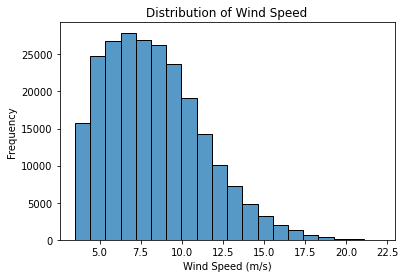

In [10]:
# create a histogram distribution for the wind speed in bins 
sns.histplot(df['wind_speed'], bins=20)
plt.title('Distribution of Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.show()


The most recorded wind speeds for the turbines are in the range of 5 to 10m/s

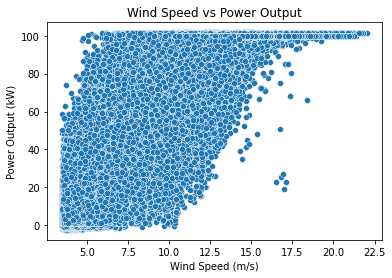

In [11]:
sns.scatterplot(x='wind_speed', y='perc_to_rated_power', data=df)
plt.title('Wind Speed vs Power Output')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.show()

In [12]:
# calculating actual power for inland turbines

rated_power = 2.5 #MW
df.loc[df['source'] == 'inland', 'actual_power_output'] = df[df['source'] == 'inland']['perc_to_rated_power'] / 100 * rated_power

In [13]:
# calculating actual power for offshore turbines

rated_power = 4.0 #MW
df.loc[df['source'] == 'offshore', 'actual_power_output'] = df[df['source'] == 'offshore']['perc_to_rated_power'] / 100 * rated_power

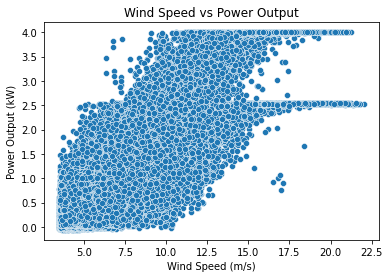

In [14]:
# lets plot again against the actual power output, combined both inland and offshore
sns.scatterplot(x='wind_speed', y='actual_power_output', data=df)
plt.title('Wind Speed vs Power Output')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.show()

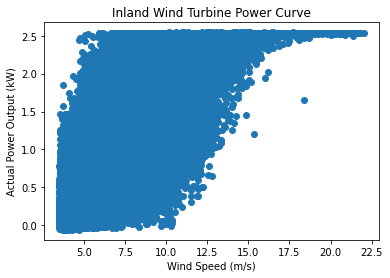

In [15]:
# plot only inland data
inland_data = df[df['source'] == 'inland']
plt.scatter(inland_data['wind_speed'], inland_data['actual_power_output'])
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Actual Power Output (kW)')
plt.title('Inland Wind Turbine Power Curve')
plt.show()


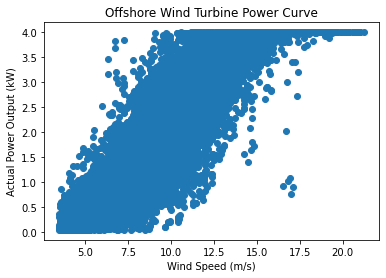

In [16]:
# plot only offshore data
offshore_data = df[df['source'] == 'offshore']
plt.scatter(offshore_data['wind_speed'], offshore_data['actual_power_output'])
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Actual Power Output (kW)')
plt.title('Offshore Wind Turbine Power Curve')
plt.show()


<p>The reason for the separate graphs looking better individually could be due to the different characteristics of the two datasets (inland and offshore) such as differences in wind speed, turbine design, and location. Plotting them separately allows us to better observe any patterns or trends that may be specific to each dataset without being obscured by the other. Additionally, it can be easier to analyze and interpret the data when it is not overcrowded with too many points.</p>

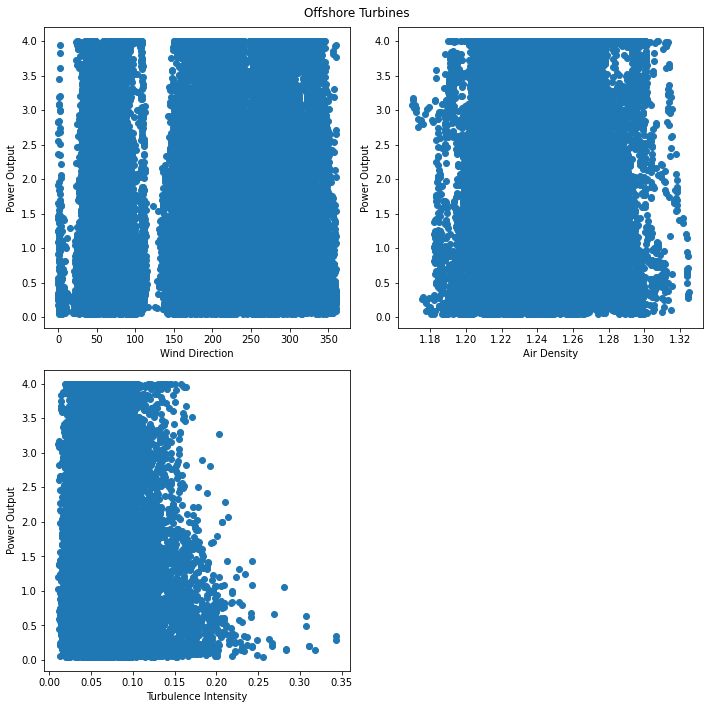

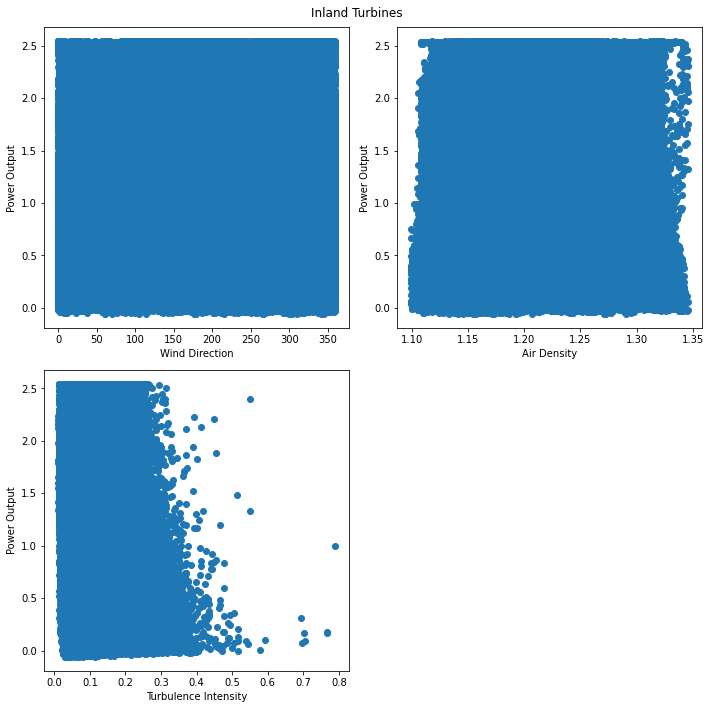

In [17]:
# further explolatory data analysis

offshore_data = df[df['source'] == 'offshore']
inland_data = df[df['source'] == 'inland']

# Plot for offshore data
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(offshore_data['wind_dir'], offshore_data['actual_power_output'])
axs[0, 0].set_xlabel('Wind Direction')
axs[0, 0].set_ylabel('Power Output')
axs[0, 1].scatter(offshore_data['air_den'], offshore_data['actual_power_output'])
axs[0, 1].set_xlabel('Air Density')
axs[0, 1].set_ylabel('Power Output')
axs[1, 0].scatter(offshore_data['turbulence_int'], offshore_data['actual_power_output'])
axs[1, 0].set_xlabel('Turbulence Intensity')
axs[1, 0].set_ylabel('Power Output')
axs[1, 1].remove()

plt.suptitle('Offshore Turbines')
plt.tight_layout()
plt.show()

# Plot for inland data
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(inland_data['wind_dir'], inland_data['actual_power_output'])
axs[0, 0].set_xlabel('Wind Direction')
axs[0, 0].set_ylabel('Power Output')
axs[0, 1].scatter(inland_data['air_den'], inland_data['actual_power_output'])
axs[0, 1].set_xlabel('Air Density')
axs[0, 1].set_ylabel('Power Output')
axs[1, 0].scatter(inland_data['turbulence_int'], inland_data['actual_power_output'])
axs[1, 0].set_xlabel('Turbulence Intensity')
axs[1, 0].set_ylabel('Power Output')
axs[1, 1].remove()

plt.suptitle('Inland Turbines')
plt.tight_layout()
plt.show()


<h3 style="size: 155px;">EDA - REMOVING OUTLIERS</h3>

<p>Calculate the interquartile range (IQR) for the 'actual_power_output' column of each dataframe. Use the IQR to calculate the lower and upper bounds for the power output column of each dataframe. Then we filter the data to remove any rows where the power output value is outside the lower and upper bounds.
The interquartile range (IQR) is a measure of the spread of a dataset. It is calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the dataset. The IQR is used to identify outliers in a dataset, which are defined as any value that falls below Q1 - 1.5IQR or above Q3 + 1.5IQR. Values outside this range are considered to be extreme values and are typically removed from the dataset.

In the context of wind energy, outliers in the power output column may be due to a variety of factors such as measurement errors, equipment malfunctions, or extreme weather conditions. By removing these outliers, we can obtain a cleaner dataset that is more representative of typical wind turbine performance.</p>



In [18]:
# Separate the inland and offshore datasets
inland_data = df[df['source'] == 'inland']
offshore_data = df[df['source'] == 'offshore']

# Define the Tukey method for outlier detection
def tukey_outlier_test(data_column):
    q1, q3 = np.percentile(data_column, [25, 75])
    iqr = q3 - q1
    low_lim = q1 - 1.5 * iqr
    up_lim = q3 + 1.5 * iqr
    return low_lim, up_lim

# Apply the Tukey method separately for inland and offshore datasets
for data in [inland_data, offshore_data]:
    for col in ['actual_power_output', 'wind_speed', 'wind_dir', 'air_den', 'turbulence_int']:
        low_lim, up_lim = tukey_outlier_test(data[col])
        data = data[(data[col] >= low_lim) & (data[col] <= up_lim)]
        
# Concatenate the filtered inland and offshore datasets
filtered_data = pd.concat([inland_data, offshore_data], axis=0)

# Save the filtered dataset to a new CSV file
filtered_data.to_csv('filtered_dataset.csv', index=False)


In [19]:
#/content/filtered_dataset.csv
# Load the new data into a DataFrame
df = pd.read_csv('/content/filtered_dataset.csv')

In [20]:
df.head(3)

,seq,wind_speed,wind_dir,air_den,turbulence_int,below_hub_wshear,perc_to_rated_power,source,wind_turbine,actual_power_output
0,1,7.96,138.9,1.140224,0.090452,0.266512,39.315152,inland,WT1,0.982879
1,2,8.19,140.6,1.140522,0.083028,0.286167,45.745455,inland,WT1,1.143636
2,3,7.20,139.3,1.140771,0.098611,0.339321,38.212121,inland,WT1,0.955303


In [19]:
df.tail(3)

,seq,wind_speed,wind_dir,air_den,turbulence_int,below_hub_wshear,perc_to_rated_power,source,wind_turbine,actual_power_output
235592,19042,13.33419,49.20426,1.268040,0.089151,0.040520,86.876667,offshore,WT6,3.475067
235593,19043,13.74909,50.82530,1.267944,0.083368,0.046540,85.716667,offshore,WT6,3.428667
235594,19044,13.60807,51.76233,1.267011,0.069810,0.041815,87.420000,offshore,WT6,3.496800


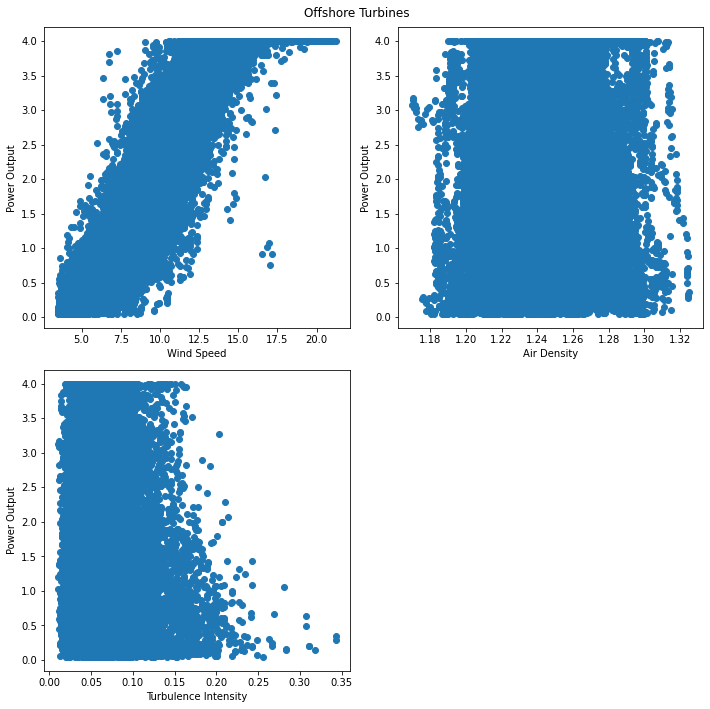

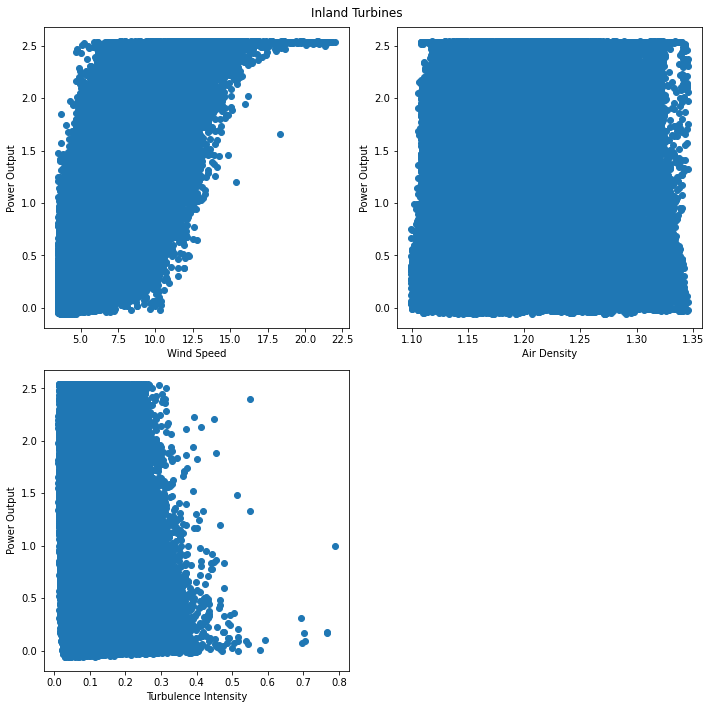

In [21]:
# re-visualizing after removing supposed outliers

offshore_data = df[df['source'] == 'offshore']
inland_data = df[df['source'] == 'inland']

# Plot for offshore data
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(offshore_data['wind_speed'], offshore_data['actual_power_output'])
axs[0, 0].set_xlabel('Wind Speed')
axs[0, 0].set_ylabel('Power Output')
axs[0, 1].scatter(offshore_data['air_den'], offshore_data['actual_power_output'])
axs[0, 1].set_xlabel('Air Density')
axs[0, 1].set_ylabel('Power Output')
axs[1, 0].scatter(offshore_data['turbulence_int'], offshore_data['actual_power_output'])
axs[1, 0].set_xlabel('Turbulence Intensity')
axs[1, 0].set_ylabel('Power Output')
axs[1, 1].remove()

plt.suptitle('Offshore Turbines')
plt.tight_layout()
plt.show()

# Plot for inland data
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(inland_data['wind_speed'], inland_data['actual_power_output'])
axs[0, 0].set_xlabel('Wind Speed')
axs[0, 0].set_ylabel('Power Output')
axs[0, 1].scatter(inland_data['air_den'], inland_data['actual_power_output'])
axs[0, 1].set_xlabel('Air Density')
axs[0, 1].set_ylabel('Power Output')
axs[1, 0].scatter(inland_data['turbulence_int'], inland_data['actual_power_output'])
axs[1, 0].set_xlabel('Turbulence Intensity')
axs[1, 0].set_ylabel('Power Output')
axs[1, 1].remove()

plt.suptitle('Inland Turbines')
plt.tight_layout()
plt.show()

<h3 style="size: 155px;">FEATURE SELECTION - CORRELATION ANALYSIS</h3>

<p>Feature selection is a crucial step in machine learning, where we aim to select a subset of features that are most predictive of the target variable. This helps to reduce the complexity of the model, improve its performance, and avoid overfitting.

Correlation analysis involves calculating the correlation coefficients between the target variable (power output) and the input features. Features with high correlation coefficients (either positive or negative) are considered to be highly predictive of the target variable and are retained, while features with low correlation coefficients are discarded.

Overall, the goal of feature selection is to reduce the number of input features while maintaining or improving the performance of the model..</p>



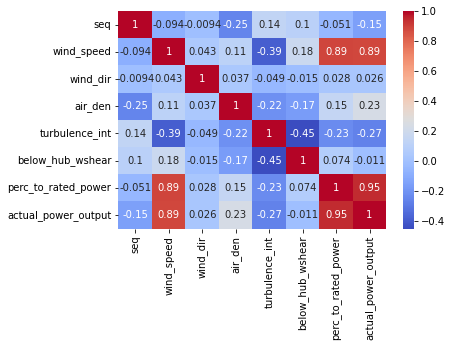

In [40]:
# calculate correlation matrix
corr_matrix = df.corr()

# visualize correlation matrix as heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# select features with correlation above threshold
corr_threshold = 0.5
corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            corr_features.add(corr_matrix.columns[i])
            

<p>In this case, reading the heat map shows that the wind speed has the highest correlation with the target variable (actual_power_output) with a value of 0.89.</p>

<h3 style="size: 155px;">MODEL SELECTION - RANDOM FOREST REGRESSION</h3>

<p>Random forest regression is a type of ensemble learning method that uses decision trees to model the relationship between input features and the target variable. It involves constructing multiple decision trees at training time and outputting the mean prediction of the individual trees.

The number of trees in a random forest model is a hyperparameter that needs to be tuned. The general rule of thumb is that increasing the number of trees in the model improves the model's performance, but this comes at the cost of longer training times and increased computational resources. In practice, the optimal number of trees for a random forest model depends on the size and complexity of the dataset.

In this case, the choice of 100 decision trees was arbitrary, and it was chosen to provide a good balance between performance and computational efficiency. However, it's always a good idea to experiment with different hyperparameters and evaluate the model's performance to find the optimal values.
</p>



In [37]:
# Splitting the data into input features and target variable
X = df[['wind_speed', 'air_den']]
y = df['actual_power_output']

# Creating a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model on the data
rf_model.fit(X, y)

# Predicting the power output using the trained model
y_pred = rf_model.predict(X)


<h3 style="size: 155px;">MODEL SELECTION - GRADIENT BOOST(XGBOOST)</h3>

<p>XGBoost is a type of gradient boosting algorithm, which means it belongs to the same family of algorithms as gradient boosting. However, XGBoost is a specific implementation of gradient boosting that uses a different optimization strategy and includes additional features and enhancements, such as regularization, tree pruning, and parallel processing, which can improve performance and accuracy.
</p>

In [38]:
# create an instance of the model

# split data into train and test sets
X = df[['wind_speed', 'air_den']]
y = df['actual_power_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create xgboost regressor object
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100,
                              learning_rate=0.1,
                              max_depth=3,
                              min_child_weight=1,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              gamma=0,
                              reg_alpha=0,
                              reg_lambda=1)

# fit the model on the training data
xgb_model.fit(X_train, y_train)

# make predictions on the test data
y_pred = xgb_model.predict(X_test)

# calculate and print the RMSE
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print("RMSE:", rmse)


<h3 style="size: 155px;">MODEL SELECTION - SUPPORT VECTOR REGRESSOR (SVR)</h3>

<p>Support Vector Regressor (SVR) is a type of regression model that uses the Support Vector Machine (SVM) algorithm to predict continuous variables. It is used for regression tasks, where the goal is to predict a continuous variable instead of a categorical variable.

The advantage of using an SVR is that it can handle complex data sets with a large number of features. It can also handle non-linear relationships between the input variables and the output variable, by using a kernel function to map the input variables to a higher-dimensional space.

SVR is also effective in dealing with outliers, since the algorithm tries to minimize the error on the training set, while still keeping the error within a certain margin, called the epsilon-insensitive zone. This margin helps to prevent overfitting and makes the model more robust to noise and outliers in the data.</p>



<p>The implementation of the standard SVR with rbf kernel is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples.

The support vector regression (SVR) model can be computationally intensive and may require more resources compared to other regression models, especially with a large dataset. This is because the model is trying to find the best hyperplane that separates the data points into different classes or predicts the target variable with high accuracy, which can be a complex optimization problem. However, there are some techniques that can be used to optimize the training process and reduce the computational time, such as kernel approximations, early stopping, and model parallelization

For large datasets consider using LinearSVR or SGDRegressor instead, possibly after a Nystroem transformer or other Kernel Approximation. 

Using linear SVR instead of kernel-based SVR can reduce the computational cost and increase the scalability of the model, but it can also reduce the accuracy of the predictions, especially if the data has complex nonlinear relationships. However, in some cases, linear SVR can still provide reasonable accuracy and is a good option when dealing with large datasets.
.</p>

In [33]:
# split data into train and test sets
X = df[['wind_speed', 'air_den']]
y = df['actual_power_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# create the LinearSVR estimator
linear_svr = LinearSVR(epsilon=0.0, tol=0.0001, C=1.0, max_iter=50000)

# fit the model on the training data
linear_svr.fit(X_train, y_train)

# make predictions on the test data
y_pred = linear_svr.predict(X_test)

# evaluate the model using mean squared error
#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)


it was having convergence issues, so the number of features was reduced and the iteration numbers increased in each steps of 1,000, 5,000, 10,000, 15,000 up till 50,000. this was were convergence was achieved.
50,000 iterations seem quite high. It may indicate that the model is not well suited for this data or that the data itself is noisy or has high variance.
In general, the number of features that can be used depends on various factors such as the number of observations, the complexity of the model, and the quality of the features. In some cases, using too many features can lead to overfitting, while in others, it may not significantly improve the performance of the model.

It's recommended to perform feature selection or dimensionality reduction techniques such as PCA to identify the most relevant features and remove the redundant ones. This can help in improving the model's performance and reducing the training time.

<h3 style="size: 155px;">MODEL EVALUATION</h3>

<p>we can evaluate the performance of the three models: Random Forest Regression, XGBoost, and LinearSVR. To do this, we can use some evaluation metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2).</p>

In [41]:
# make predictions for the test data
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
svr_preds = linear_svr.predict(X_test)

# calculate evaluation metrics
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

svr_mae = mean_absolute_error(y_test, svr_preds)
svr_mse = mean_squared_error(y_test, svr_preds)
svr_r2 = r2_score(y_test, svr_preds)

# print the evaluation metrics
print('Random Forest Regression:')
print('MAE:', rf_mae)
print('MSE:', rf_mse)
print('R2:', rf_r2)
print()

print('XGBoost:')
print('MAE:', xgb_mae)
print('MSE:', xgb_mse)
print('R2:', xgb_r2)
print()

print('LinearSVR:')
print('MAE:', svr_mae)
print('MSE:', svr_mse)
print('R2:', svr_r2)


Random Forest Regression:
MAE: 0.11841843175740499
MSE: 0.02830686177424505
R2: 0.96896689285605

XGBoost:
MAE: 0.28008576358214987
MSE: 0.15544220838718972
R2: 0.8295870893056451

LinearSVR:
MAE: 0.30015206263055294
MSE: 0.18403044128575355
R2: 0.7982455120699612


<h3 style="size: 155px;">CONCLUSION</h3>

<p>Based on the evaluation metrics, it seems that the Random Forest Regressor model performed the best, with the lowest mean absolute error (MAE), mean squared error (MSE), and the highest R-squared value (R2). This means that the Random Forest Regressor model was able to accurately predict the wind turbine power output based on the input features.

The XGBoost model performed moderately well, with a higher MAE and MSE, and a lower R2 compared to the Random Forest Regressor model. This means that the XGBoost model was not as accurate as the Random Forest Regressor model in predicting the wind turbine power output.

The LinearSVR model performed the worst, with the highest MAE and MSE, and the lowest R2 value. This means that the LinearSVR model was the least accurate in predicting the wind turbine power output.

In conclusion, the Random Forest Regressor model seems to be the best model for predicting wind turbine power output based on the given input features. However, it is important to note that the performance of the models can be further improved by tuning the hyperparameters and feature selection.
</p>